### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhoutee score


1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
# before_date = '2025-05-03 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-07 20:13:58,805 - AInewsbot - INFO - Initializing with before_date=2025-05-07 08:00, do_download=False, thread_id=06fe27ddf0fc416096ac939688fc748e


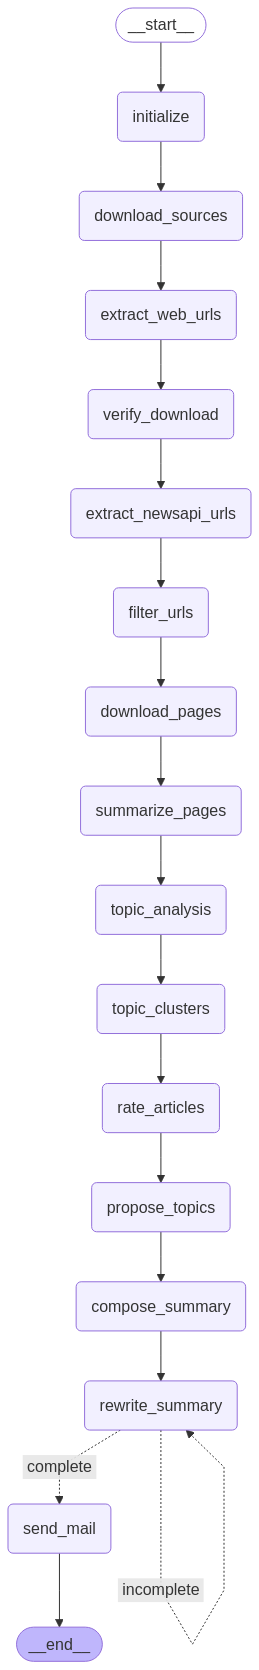

In [12]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-07 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [13]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-07 20:13:59,540 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-07 20:13:59,541 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-07 20:13:59,542 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-07 20:13:59,542 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-07 20:13:59,543 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-07 20:13:59,543 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-07 20:13:59,544 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [14]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-07 20:14:00,115 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-07 20:14:00,117 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-07 20:14:00,117 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-07 20:14:00,118 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-07 20:14:00,118 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-07 20:14:00,118 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-07 20:14:00,118 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-07 20:14:00,119 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-07 20:14:00,119 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-07 20:14:00,119 - AInewsbot - INFO - htmldata/FT.html
2025-05-07 20:14:00,119 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-07 20:14:00,120 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-07 20:14:00,120 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-07 20:14:00,120 - AInewsbot - INFO -

In [15]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-07 20:14:00,621 - AInewsbot - INFO - Parsing html files
2025-05-07 20:14:00,622 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-07 20:14:00,667 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-07 20:14:00,670 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-07 20:14:00,670 - AInewsbot - INFO - 34 links found
2025-05-07 20:14:00,670 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-07 20:14:00,690 - AInewsbot - INFO - parse_file - found 246 raw links
2025-05-07 20:14:00,693 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-07 20:14:00,693 - AInewsbot - INFO - 37 links found
2025-05-07 20:14:00,693 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-07 20:14:00,712 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-07 20:14:00,714 - AInewsbot - INFO - parse_file - found 20 filtered links
2025-05-07 20:14:00,715 - AInewsbot - INFO - 20 links found
2025-05-07

In [16]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,34
Bloomberg,30
Business Insider,20
FT,66
Feedly AI,29
Hacker News 1,27
Hacker News 2,24
HackerNoon,123
New York Times,18


number of missing sources 0


set()

In [17]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-07 20:14:03,066 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [18]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-07 20:14:05,382 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-06T20:14:05 from NewsAPI


In [19]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-07 20:14:06,941 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-07 08:00'
2025-05-07 20:14:07,590 - AInewsbot - INFO - URLs in orig_df: 966
2025-05-07 20:14:07,594 - AInewsbot - INFO - Existing URLs in DB: 255272
2025-05-07 20:14:07,664 - AInewsbot - INFO - New URLs in df filtered by URL: 402
2025-05-07 20:14:07,810 - AInewsbot - INFO - Existing src+title: 33
2025-05-07 20:14:07,810 - AInewsbot - INFO - New URLs in df filtered by src+title: 369
2025-05-07 20:14:07,825 - AInewsbot - INFO - Found 369 unique new headlines
2025-05-07 20:14:07,828 - AInewsbot - INFO - Found 366 unique cleaned new headlines
2025-05-07 20:14:11,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:14:15,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:14:15,830 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,2
Bloomberg,9
Business Insider,5
FT,6
Feedly AI,20
Hacker News 1,6
Hacker News 2,3
HackerNoon,14
New York Times,1


In [20]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-07 20:14:21,390 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-07 20:14:21,402 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-07 20:14:21,753 - AInewsbot - INFO - Launching browser
2025-05-07 20:14:23,418 - AInewsbot - INFO - Launching workers
2025-05-07 20:14:23,418 - AInewsbot - INFO - Launching worker
2025-05-07 20:14:23,418 - AInewsbot - INFO - from queue: 0, https://modal.com/blog/gpu-utilization-guide , 'I paid for the whole GPU, I am going to use the whole GPU'
2025-05-07 20:14:23,419 - AInewsbot - INFO - fetch_url(https://modal.com/blog/gpu-utilization-guide)
2025-05-07 20:14:23,419 - AInewsbot - INFO - File already exists: htmlpages/I_paid_for_the_whole_GPU__I_am_going_to_use_the_whole_GPU.html
2025-05-07 20:14:23,419 - AInewsbot - INFO - from queue: 1, https://www.kdnuggets.com/3-excellent-practical-generative-ai-courses , 3 Excellent Practical Generative AI Courses
2025-05-07 20:14:23,419 - AInewsbot - INFO - fetch_url(https://www.k

2025-05-07 20:14:23,698 - AInewsbot - INFO - Launching worker
2025-05-07 20:14:23,698 - AInewsbot - INFO - from queue: 16, https://www.ft.com/content/daaf1fe5-615d-4f52-90c4-18aac6d542e5 , Alphabet shares slide as Apple seeks AI alternatives to Google search
2025-05-07 20:14:23,698 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/daaf1fe5-615d-4f52-90c4-18aac6d542e5)
2025-05-07 20:14:23,699 - AInewsbot - INFO - File already exists: htmlpages/Alphabet_shares_slide_as_Apple_seeks_AI_alternatives_to_Google_search.html
2025-05-07 20:14:23,699 - AInewsbot - INFO - from queue: 17, https://www.theguardian.com/technology/2025/may/07/amazon-makes-fundamental-leap-forward-in-robotics-with-device-having-sense-of-touch , Amazon unveils Vulcan, a sorting robot with a sense of touch that will be able to grab ~75% of its warehouse items, rolling out globally in the next few years
2025-05-07 20:14:23,699 - AInewsbot - INFO - fetch_url(https://www.theguardian.com/technology/2025/may/07/amazon-

2025-05-07 20:14:44,994 - AInewsbot - INFO - File already exists: htmlpages/Chatbot_vs_AI_Agent__The_Difference_Everyone_Talks_Around_but_Rarely_Gets_Right.html
2025-05-07 20:14:44,994 - AInewsbot - INFO - from queue: 31, https://www.wsj.com/tech/cisco-systems-introduces-new-quantum-chip-opens-lab-facility-9cac05f3 , Cisco Systems Introduces New Quantum Chip, Opens Lab Facility
2025-05-07 20:14:44,994 - AInewsbot - INFO - Skipping fetch for 31 https://www.wsj.com/tech/cisco-systems-introduces-new-quantum-chip-opens-lab-facility-9cac05f3 Cisco Systems Introduces New Quantum Chip, Opens Lab Facility
2025-05-07 20:14:44,994 - AInewsbot - INFO - from queue: 32, https://github.com/asgeirtj/system_prompts_leaks/blob/main/claude.txt , Claude's system prompt is over 24k tokens with tools
2025-05-07 20:14:44,995 - AInewsbot - INFO - fetch_url(https://github.com/asgeirtj/system_prompts_leaks/blob/main/claude.txt)
2025-05-07 20:14:46,688 - AInewsbot - INFO - Saving HTML to htmlpages/A_look_at_the

2025-05-07 20:14:47,880 - AInewsbot - INFO - Skipping fetch for 45 https://www.bloomberg.com/news/articles/2025-05-07/france-s-mistral-releases-ai-model-tailored-for-businesses Frances Mistral Releases AI Model Tailored for Businesses
2025-05-07 20:14:47,881 - AInewsbot - INFO - from queue: 46, https://hackernoon.com/from-beginner-to-aiml-pro-in-2025-the-step-by-step-roadmap-that-gets-you-hired , From Beginner to AI/ML Pro in 2025: The Step-by-Step Roadmap that Gets You Hired
2025-05-07 20:14:47,881 - AInewsbot - INFO - fetch_url(https://hackernoon.com/from-beginner-to-aiml-pro-in-2025-the-step-by-step-roadmap-that-gets-you-hired)
2025-05-07 20:14:47,881 - AInewsbot - INFO - Waiting 46.023115368590844 seconds to rate limit hackernoon.com 1.0939569169422612
2025-05-07 20:14:48,773 - AInewsbot - INFO - Saving HTML to htmlpages/Alignment_is_not_free__How_model_upgrades_can_silence_your_confidence_signals.html
2025-05-07 20:14:48,810 - AInewsbot - INFO - from queue: 47, https://www.globene

2025-05-07 20:15:16,133 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/ce669661112d1ea0)
2025-05-07 20:15:16,133 - AInewsbot - INFO - File already exists: htmlpages/IBMs_Gary_Cohn_on_the_tariff-driven_environment_of_uncertainties_holding_back_AI.html
2025-05-07 20:15:16,134 - AInewsbot - INFO - from queue: 61, https://www.newsweek.com/ai-race-fossil-powered-generators-are-data-centers-dirty-secret-2068791 , In the AI Race, Fossil-Powered Generators are Data Centers' Dirty Secret
2025-05-07 20:15:16,134 - AInewsbot - INFO - fetch_url(https://www.newsweek.com/ai-race-fossil-powered-generators-are-data-centers-dirty-secret-2068791)
2025-05-07 20:15:16,134 - AInewsbot - INFO - File already exists: htmlpages/In_the_AI_Race__Fossil-Powered_Generators_are_Data_Centers__Dirty_Secret.html
2025-05-07 20:15:16,134 - AInewsbot - INFO - from queue: 62, https://www.anthropic.com/news/web-search-api , Introducing Web Search on the Anthropic API
2025-05-07 20:15:16,134 - AInewsbot - INFO - fetch_

2025-05-07 20:15:27,417 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/mistral-comes-out-swinging-for-enterprise-ai-customers-with-new-le-chat-enterprise-medium-3-model/)
2025-05-07 20:15:27,419 - AInewsbot - INFO - File already exists: htmlpages/Mistral_comes_out_swinging_for_enterprise_AI_customers_with_new_Le_Chat_Enterprise__Medium_3_model.html
2025-05-07 20:15:27,421 - AInewsbot - INFO - from queue: 77, https://techcrunch.com/2025/05/07/mistral-claims-its-newest-ai-model-delivers-leading-performance-for-the-price/ , Mistral releases Medium 3, which it says focuses on efficiency without compromising performance, for $0.40 per 1M input tokens, and launches Le Chat Enterprise
2025-05-07 20:15:27,422 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/05/07/mistral-claims-its-newest-ai-model-delivers-leading-performance-for-the-price/)
2025-05-07 20:15:27,425 - AInewsbot - INFO - File already exists: htmlpages/Mistral_releases_Medium_3__which_it_says_focuses_on_effic

2025-05-07 20:15:52,301 - AInewsbot - INFO - from queue: 91, https://openai.com/global-affairs/openai-for-countries/ , OpenAI for Countries
2025-05-07 20:15:52,302 - AInewsbot - INFO - fetch_url(https://openai.com/global-affairs/openai-for-countries/)
2025-05-07 20:15:52,302 - AInewsbot - INFO - File already exists: htmlpages/OpenAI_for_Countries.html
2025-05-07 20:15:52,303 - AInewsbot - INFO - from queue: 92, https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046 , OpenAI plans Stargate expansion outside US
2025-05-07 20:15:52,303 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)
2025-05-07 20:15:52,305 - AInewsbot - INFO - Waiting 20.50115190400761 seconds to rate limit www.ft.com 19.880610499996692
2025-05-07 20:15:54,069 - AInewsbot - INFO - Saving HTML to htmlpages/Jesse_Levinson_of_Amazon_Zoox__The_public_has_less_patience_for_robotaxi_mistakes.html
2025-05-07 20:15:54,132 - AInewsbot - INFO - from queue: 93, https://www.blo

2025-05-07 20:16:00,137 - AInewsbot - INFO - File already exists: htmlpages/Sources__OpenAI_staffers_met_with_the_FDA_and_two_DOGE_associates_multiple_times_in_recent_weeks_to_discuss_a_project_called_cderGPT__likely_for_drug_evaluation.html
2025-05-07 20:16:00,139 - AInewsbot - INFO - from queue: 106, https://www.theinformation.com/briefings/former-openai-deepmind-leaders-seek-funding-chatgpt-material-science , Sources: Periodic Labs, which is building a ChatGPT for material science, is seeking to raise $100M+ at a $1B+ valuation, just two months after its founding
2025-05-07 20:16:00,143 - AInewsbot - INFO - fetch_url(https://www.theinformation.com/briefings/former-openai-deepmind-leaders-seek-funding-chatgpt-material-science)
2025-05-07 20:16:11,790 - AInewsbot - INFO - Saving HTML to htmlpages/OpenAI_Forced_to_Abandon_Plans_to_Become_For-Profit.html
2025-05-07 20:16:12,119 - AInewsbot - INFO - from queue: 107, https://www.bloomberg.com/news/articles/2025-05-07/south-korea-s-han-vow

2025-05-07 20:16:36,185 - AInewsbot - INFO - from queue: 121, https://www.huffpost.com/entry/donald-trump-ai-pope-image-catholic-scholars_n_681a22b0e4b0c2b15d966638 , Trump's Flippant 5-Word Response To Criticism Over 'Fun' AI Pope Image Speaks Volumes
2025-05-07 20:16:36,188 - AInewsbot - INFO - fetch_url(https://www.huffpost.com/entry/donald-trump-ai-pope-image-catholic-scholars_n_681a22b0e4b0c2b15d966638)
2025-05-07 20:16:36,763 - AInewsbot - INFO - Saving HTML to htmlpages/Parloa_raises__120M_at__1B_valuation_to_expand_enterprise_AI_agent_platform.html
2025-05-07 20:16:36,869 - AInewsbot - INFO - from queue: 122, https://www.theregister.com/2025/05/07/us_export_controls_on_instinct/ , Trump's trade war with China to cost AMD $1.5B in lost revBut a multi-billion dollar contract with Oracle for a pile of Instincts and Epycs should take the edge offAI Infrastructure Month20 hrs|3
2025-05-07 20:16:36,870 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/05/07/us_export_co

In [21]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-07 20:17:29,720 - AInewsbot - INFO - Starting summarize
2025-05-07 20:17:29,723 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-07 20:17:29,724 - AInewsbot - INFO - Attempting to fetch summaries for 134 articles
2025-05-07 20:17:29,748 - AInewsbot - INFO - clean_html - Page title: 'I paid for the whole GPU, I am going to use the whole GPU': A high-level guide to GPU utilization | Modal Blog
Social card title: 'I paid for the whole GPU, I am going to use the whole GPU': A high-level guide to GPU utilization
Social card description: A guide to maximizing the utilization of GPUs, from cloud allocations to FLOP/s.

2025-05-07 20:17:29,910 - AInewsbot - INFO - Queuing 0: Page title: 'I paid for the whole GPU, I am going ...
2025-05-07 20:17:29,923 - AInewsbot - INFO - clean_html - Page title: 3 Excellent Practical Generative AI Courses - KDnuggets
Social card title: 3 Excellent Practical Generative AI Courses
Social card description: Learn to build AI agents, fine-t

2025-05-07 20:17:30,568 - AInewsbot - INFO - Queuing 16: Page title: Subscribe to read
Social card title: A...
2025-05-07 20:17:30,583 - AInewsbot - INFO - clean_html - Page title: Amazon makes ‘fundamental leap forward in robotics’ with device having sense of touch | Robots | The Guardian
Social card title: Amazon makes ‘fundamental leap forward in robotics’ with device having sense of touch
Social card description: Vulcan device ‘capable of grabbing three-quarters of items in warehouses’ fuels fears of mass job losses

2025-05-07 20:17:30,597 - AInewsbot - INFO - Queuing 17: Page title: Amazon makes ‘fundamental leap forward...
2025-05-07 20:17:30,610 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Amazon’s Zoox to scale up robotaxi production for US expansion
Social card description: Self-driving start-up is opening a facility in California’s Bay Area to increase its fleet significantly

2025-05-07 20:17:30,628 - AInewsbot - INFO - Queuing 18: Page

2025-05-07 20:17:31,729 - AInewsbot - INFO - clean_html - Page title: Even AI Needs Glasses: When Space Images Get Too Fuzzy to Fix | HackerNoon
Social card title: Even AI Needs Glasses: When Space Images Get Too Fuzzy to Fix | HackerNoon
Social card description: Restoration falters at high noise, on stellar point sources, and with correlated artifacts-highlighting key limits of current deep learning for astronomy images

2025-05-07 20:17:31,760 - AInewsbot - INFO - Queuing 38: Page title: Even AI Needs Glasses: When Space Imag...
2025-05-07 20:17:31,805 - AInewsbot - INFO - clean_html - Page title: Rampant AI Cheating Is Ruining Education Alarmingly Fast
Social card title: Everyone Is Cheating Their Way Through College
Social card description: ChatGPT has unraveled the entire academic project.

2025-05-07 20:17:31,862 - AInewsbot - INFO - Queuing 39: Page title: Rampant AI Cheating Is Ruining Educati...
2025-05-07 20:17:31,867 - AInewsbot - INFO - clean_html - Page title: Ex-Trump NSC

2025-05-07 20:17:32,444 - AInewsbot - INFO - Queuing 54: Page title: How Creati Quietly Hit $10M in AI Reve...
2025-05-07 20:17:32,460 - AInewsbot - INFO - clean_html - Page title: How small AI models trained for oil and gas are driving safer, more efficient operations | Energy Central
Social card title: How small AI models trained for oil and gas are driving safer, more efficient operations
Social card description: Oil and gas companies operate in a complex, high-stakes environment where efficiency, safety, and regulatory compliance are critical. Managing vast infrastructure, optimizing drilling operations, and ensuring equipment reliability require precision-driven solutions. However, traditional approaches to data analysis and decision-making often fall short, and even advanced artificial intelligence (AI) models struggle to meet industry-specific demands.

2025-05-07 20:17:32,491 - AInewsbot - INFO - Queuing 55: Page title: How small AI models trained for oil an...
2025-05-07 20:17

2025-05-07 20:17:33,300 - AInewsbot - INFO - Queuing 72: Page title: Mandatory AI Education For Every U.S. ...
2025-05-07 20:17:33,324 - AInewsbot - INFO - clean_html - Page title: Marketers Are Panicking About ChatGPT's Impact On SEO — Gumshoe Just Raised $2M From Top Tech Veterans To Solve The AI Search Crisis
Social card title: Marketers Are Panicking About ChatGPT's Impact On SEO — Gumshoe Just Raised $2M From Top Tech Veterans To Solve The AI Search Crisis
Social card description: Gumshoe, a Seattle-based startup, has raised $2 million in pre-seed funding to help marketers understand and influence how AI-powered search engines like ChatGPT and Claude surface brand content, according to a company statement released last week. The round was led by startup studio Pioneer Square Labs and included participation from Hawke Ventures and angel investor Ari Paparo, a recognized leader in the advertising technology space, as reported by GeekWire. Paparo previously co-founded Beeswa

2025-05

2025-05-07 20:17:33,899 - AInewsbot - INFO - clean_html - Page title: OpenAI Forced to Abandon Plans to Become For-Profit
Social card title: OpenAI Forced to Abandon Plans to Become For-Profit
Social card description: Thanks in part to erstwhile cofounder Elon Musk's lawsuit, OpenAI won't be going entirely for-profit anytime soon.

2025-05-07 20:17:33,910 - AInewsbot - INFO - Queuing 89: Page title: OpenAI Forced to Abandon Plans to Beco...
2025-05-07 20:17:33,921 - AInewsbot - INFO - clean_html - Page title: OpenAI and the FDA are reportedly discussing AI for drug evaluations | TechCrunch
Social card title: OpenAI and the FDA are reportedly discussing AI for drug evaluations | TechCrunch
Social card description: OpenAI has reportedly met with officials from the Food and Drug Administration to discuss how AI could speed up drug evaluations.

2025-05-07 20:17:33,933 - AInewsbot - INFO - Queuing 90: Page title: OpenAI and the FDA are reportedly disc...
2025-05-07 20:17:33,943 - AInewsbot

2025-05-07 20:17:34,747 - AInewsbot - INFO - Queuing 106: Page title: Former OpenAI and Deepmind Leaders See...
2025-05-07 20:17:34,747 - AInewsbot - INFO - No path for 107
2025-05-07 20:17:34,763 - AInewsbot - INFO - clean_html - Page title: Stripe unveils AI foundation model for payments, reveals ‘deeper partnership’ with Nvidia | TechCrunch
Social card title: Stripe unveils AI foundation model for payments, reveals ‘deeper partnership’ with Nvidia | TechCrunch
Social card description: Fintech giant Stripe announced Wednesday a slew of new product launches at its annual Stripe Sessions user event. The highlights include: a new AI

2025-05-07 20:17:34,784 - AInewsbot - INFO - Queuing 108: Page title: Stripe unveils AI foundation model for...
2025-05-07 20:17:34,800 - AInewsbot - INFO - clean_html - Page title: Game, Sett, funding: A startup building AI agents for game development emerges from stealth with $27M | TechCrunch
Social card title: Game, Sett, funding: A startup building AI 

2025-05-07 20:17:35,438 - AInewsbot - INFO - Queuing 126: Page title: WEF Calls for Disinformation to Be Tre...
2025-05-07 20:17:35,460 - AInewsbot - INFO - clean_html - Page title: GitHub - VictorTaelin/WebMonkeys: Massively parallel GPU programming on JavaScript, simple and clean.
Social card title: GitHub - VictorTaelin/WebMonkeys: Massively parallel GPU programming on JavaScript, simple and clean.
Social card description: Massively parallel GPU programming on JavaScript, simple and clean. - VictorTaelin/WebMonkeys

2025-05-07 20:17:35,486 - AInewsbot - INFO - Queuing 127: Page title: GitHub - VictorTaelin/WebMonkeys: Mass...
2025-05-07 20:17:35,503 - AInewsbot - INFO - clean_html - Page title: NetApp’s vision for enterprise AI readiness at scale - SiliconANGLE
Social card title: NetApp’s vision for enterprise AI readiness at scale - SiliconANGLE
Social card description: NetApp explores enterprise AI readiness with secure, scalable data strategies built to support modern workloads a

async_langchain: 0, {'article': "Page title: 'I paid for the whole GPU, I am going to use the whole GPU': A high-level guide to GPU utilization | Modal Blog\nSocial card title: 'I paid for the whole GPU, I am going to use the whole GPU': A high-level guide to GPU utilization\nSocial card description: A guide to maximizing the utilization of GPUs, from cloud allocations to FLOP/s.\nGraphics Processing Units, or GPUs, are the hottest mathematical co-processor since the FM synthesis chips that shaped the sounds of the 1990s.\nLike all co-processors, they are chosen when the performance of more flexible commodity hardware, like an x86 Central Processing Unit (CPU), is insufficient. GPUs are in particular designed for problems where CPUs cannot achieve the desired throughput of mathematical operations (in particular, matrix multiplications).\nBut GPUs are not cheap: high performance can command a high price.\nCombined together, the high price, performance sensitivity, and throughput-orienta

2025-05-07 20:17:37,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: no content
async_langchain: 64 response: no content
async_langchain: 111 response: no content
async_langchain: 18 response: no content
async_langchain: 98 response: no content


2025-05-07 20:17:37,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 115 response: no content


2025-05-07 20:17:37,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 124 response: no content
async_langchain: 92 response: • OpenAI is planning to expand its "Stargate" artificial intelligence infrastructure outside the US, with global spending expected to exceed its $500 billion target for domestic investment.
async_langchain: 104 response: • Meta has resumed development of facial recognition technology, considering its integration into products like smart glasses, as executives believe privacy concerns have diminished since the technology was paused in 2021.


2025-05-07 20:17:37,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:37,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 60 response: • Gary Cohn, IBM vice chairman, stated that an “environment of uncertainties,” including tariff-driven issues, is holding back corporate investment in artificial intelligence technology.
• Cohn highlighted that unpredictability around trade and tariffs is discouraging companies from making significant AI investments.
async_langchain: 105 response: • High-ranking OpenAI employees have held multiple meetings with the US Food and Drug Administration (FDA) in recent weeks to discuss the agency’s potential use of AI, including a project called cderGPT.
• The discussions are part of a broader FDA initiative to explore how AI technology could be used to accelerate the drug approval process.
async_langchain: 28 response: • COMPUTEX 2025 opened on May 6 with the AI NEXT Forum, highlighting artificial intelligence as the central theme of the event.
• Paul Peng, chairman of the Taipei Computer Association, stated that over 60% of exhibitor booths are focused on AI-dr

2025-05-07 20:17:38,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 16 response: • Alphabet shares fell after reports that Apple is exploring artificial intelligence-based alternatives to Google search for use on iPhones and the Safari browser, according to statements from a senior Apple executive.
async_langchain: 33 response: • Google has launched image generation and editing capabilities in preview for developers using Gemini 2.0 Flash, available via the Gemini API in Google AI Studio and Vertex AI.

• The update includes higher rate limits and improved pricing, with further improvements and new features planned.

• Developers can access these capabilities under the model name “gemini-2.0-flash-preview-image-generation” and try them out with the Gemini Co-Drawing Sample App.
async_langchain: 129 response: • Social media platforms like TikTok and AI-driven video content are increasingly competing with traditional streaming services like Netflix as the streaming landscape evolves to become more social-focused.
• Streaming services are

2025-05-07 20:17:38,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: • Google updated its Gemini iOS app to offer an optimized, full-screen interface for iPad users, along with a new Home Screen widget and integration with Google Photos.
• The update also includes UI improvements and bug fixes, enhancing the overall app experience on iOS devices.
• Gemini remains free to use, while the more advanced Gemini Advanced version requires a $19.99/month Google One AI Premium subscription.
async_langchain: 90 response: • OpenAI has met with officials from the U.S. Food and Drug Administration (FDA) to discuss using AI, specifically a project called cderGPT, to speed up drug evaluations, according to a report from Wired.  
• The cderGPT tool is being considered for the FDA’s Center for Drug Evaluation, which regulates over-the-counter and prescription drugs in the U.S., and associates from Elon Musk’s DOGE have reportedly participated in the discussions.  
• The collaboration aims to accelerate drug development timelines, but there 

2025-05-07 20:17:38,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,755 - httpx 

async_langchain: 87 response: • OpenAI is acquiring AI coding assistant Windsurf, formerly known as Codeium, for about $3 billion in its largest purchase to date, though the deal is not yet finalized.
• Windsurf, founded in 2021, uses AI to help developers autocomplete code, explain code functions, and fix bugs in more than 70 programming languages, and integrates with popular coding environments like VSCode.
• OpenAI aims to integrate Windsurf’s technology into its own developer tools, such as those found in ChatGPT, to enhance its offerings amid growing competition from Microsoft’s GitHub Copilot and Anthropic’s Claude.
async_langchain: 91 response: • OpenAI has launched "OpenAI for Countries," a new initiative to help nations build AI infrastructure based on democratic principles, as part of its broader Stargate project.
• The program offers formal partnerships with governments to establish secure in-country data centers, provide localized versions of ChatGPT, enhance AI security an

2025-05-07 20:17:38,831 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:38,914 - httpx 

async_langchain: 73 response: • Seattle-based startup Gumshoe has raised $2 million in pre-seed funding to help marketers understand and influence how AI-powered search engines like ChatGPT and Claude surface brand content; the round was led by Pioneer Square Labs with participation from Hawke Ventures and angel investor Ari Paparo.  
• Gumshoe's platform simulates conversations with leading AI models to analyze brand visibility (“share of LLM”) and track which sources are cited, offering brands insights into how they appear in AI-generated search results.  
• The company, co-founded by industry veterans including Todd Sawicki and Patrick O'Donnell, is currently in public beta and plans to introduce a paywall and AI-optimization tools later this year amidst shifting search paradigms as AI platforms integrate more shopping and product recommendations.
async_langchain: 127 response: • WebMonkeys is a JavaScript library enabling massively parallel GPU programming with a simple API, allowi

2025-05-07 20:17:39,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,129 - httpx 

async_langchain: 100 response: • SAS and Intel are collaborating to redefine AI architecture with "optimized intelligence," moving beyond a GPU-first approach by tailoring hardware and software to specific AI workloads for improved performance and cost efficiency.  
• Their technical partnership has led to significant performance boosts on SAS's Viya platform using Intel hardware, including a 24% increase in speed tests and a 94% increase in throughput tests.  
• Executives from both companies emphasize a flexible, consultative AI strategy that aligns solutions with customer needs, supporting workload-specific acceleration, ethical AI, and trust in real-world outcomes across hybrid and multicloud environments.
async_langchain: 128 response: • NetApp is focusing on enterprise AI readiness by advancing its Intelligent Data Infrastructure, aiming to provide a unified, secure, and high-performing platform for AI workloads across hybrid and multicloud environments.
• The company has expande

2025-05-07 20:17:39,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,434 - httpx 

async_langchain: 20 response: • Anthropic has launched a new API enabling its Claude AI models to perform web searches, allowing developers to build apps that access up-to-date information without managing their own web search infrastructure.  
• The web search API lets Claude determine when to retrieve real-time or specialized information, generate and analyze search queries, and provide answers with citations; developers can customize search domains and permissions at the organization level.  
• Anthropic is also adding web search capabilities to Claude Code, enabling access to current API documentation and technical resources, though Claude Code remains in beta as a research preview.
async_langchain: 41 response: • Cloud-native Managed File Transfer (MFT) platforms, when combined with AI, are increasingly essential for secure, automated, large-scale data movement in modern organizations, particularly in regulated industries like finance and healthcare.
• Oded Nahum, Global Head of C

2025-05-07 20:17:39,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,518 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,574 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,590 - httpx 

async_langchain: 58 response: • Aoostar GT37 mini PC, priced at $829, features a 12-core AMD Ryzen AI 9 HX-370 processor (4 Zen 5, 8 Zen 5C), 80 TOPS AI engine, integrated Radeon 890M GPU, and supports up to three 8K/60Hz HDR displays.
• The device includes 32GB LPDDR5X RAM, a 1TB PCIe 4.0 NVMe SSD (upgradable to 4TB), OCuLINK port for external GPUs, Wi-Fi 7, Bluetooth 5.3, dual 2.5G Ethernet, USB4, HDMI 2.1, DisplayPort 2.1, and ships with Windows 11 Pro.
• At 4.41 x 2.36 x 4.41 inches, the GT37 offers workstation-level power and AI capabilities in a compact form, backed by a dedicated fan for storage cooling and a 12-month warranty.
async_langchain: 46 response: • The article provides a detailed step-by-step roadmap for becoming job-ready in AI/ML by 2025, emphasizing mastery of Python, a strong math foundation, machine learning fundamentals, hands-on projects, MLOps skills, specialization in areas like NLP or computer vision, staying updated with research, and focused job interview 

2025-05-07 20:17:39,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 32 response: • A file named "claude.txt" containing 1,110 lines of prompt engineering and system instructions related to the Claude AI assistant has been publicly posted on the GitHub repository asgeirtj/system_prompts_leaks, revealing detailed internal configurations and operational guidelines for the model.  
• The leaked content includes explicit rules for citation, artifact creation, language use, user interaction boundaries, and sensitive topic handling, offering insight into Claude's behavior, restrictions, and prompts that shape its responses.  
• This disclosure provides transparency into Anthropic's design and safety choices for Claude, but may also raise concerns regarding model misuse, intellectual property, and the challenges of securing AI system prompts from public exposure.
async_langchain: 34 response: • Apple executive Eddie Cue testified that Apple is "actively looking at" adding AI search engines to mobile Safari, which could challenge Google's domin

2025-05-07 20:17:39,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:39,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:40,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 103 response: • Jesse Cunningham, an SEO specialist, openly describes using AI to mass-produce fake content—such as recipes and home decor posts—targeting older women on platforms like Facebook and Pinterest to drive traffic and monetize engagement.

• Cunningham creates large quantities of AI-generated articles and images, posts them under invented personas with AI-generated headshots, and aggressively replicates viral content, aiming to dominate Pinterest and Facebook algorithms; he does not clearly disclose the synthetic nature of his content to users.

• Established bloggers and content creators report significant business losses due to such tactics, with one, Rachel Farnsworth, saying, "It's devastating to us bloggers, the content creators... It's just a bunch of fraud."

• Pinterest and Facebook are reportedly working to improve detection and labeling of AI-generated content, but have not commented publicly on this specific case.
async_langchain: 71 response: • L

2025-05-07 20:17:40,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:40,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:40,361 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 17 response: • Amazon unveiled a new warehouse robot named Vulcan, described as a "fundamental leap forward in robotics" due to its AI-enabled sense of touch, allowing it to autonomously handle about three-quarters of items in its warehouses.  
• Vulcan can identify objects by touch, stow items on different shelving unit levels, and is designed to work alongside humans, reducing the need for them to use ladders or bend frequently.  
• The development raises concerns over potential job losses due to automation, but Amazon's chief technologist Tye Brady emphasized that humans will remain essential in operations for oversight, problem-solving, and safety, stating, "People will always be part of the equation."  
• Amazon will also install machine-learning powered packaging automation in European warehouses, aiming to reduce waste, with over 70 machines being deployed across Germany, UK, France, Italy, and Spain by the end of 2024.
async_langchain: 126 response: • The World

2025-05-07 20:17:40,376 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:40,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:40,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 2 response: • A single ChatGPT query typically uses about 3 watt-hours (Wh) of electricity, though more recent estimates suggest this may be as low as 0.3 Wh per query due to efficiency improvements.

• The carbon footprint of using ChatGPT is small: for an average user doing 10 queries a day for a year, total emissions are estimated at 11 kilograms of CO2—just 0.16% of the average UK per-person energy-and-industry emissions.

• In comparison to everyday activities, the energy and carbon impacts from using ChatGPT are negligible for individual users and much lower than other common actions such as home heating, driving, or dietary choices.
async_langchain: 39 response: • The widespread use of generative AI tools like ChatGPT has led to rampant academic cheating in colleges and universities, with many students using AI to complete essays, coding assignments, and exams, often with minimal effort or oversight.
• Efforts by faculty to detect and prevent AI-based cheating—s

2025-05-07 20:17:40,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:40,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 132 response: • Zed has launched the Agent Panel, introducing AI-powered coding features within its open-source, Rust-built code editor, which allows users to instruct an AI agent to analyze, modify, and write code directly in the editor without prior codebase indexing.  
• The AI features are privacy-focused by default, do not store user data unless feedback is explicitly submitted, and offer granular control over which tools and capabilities agents may access; models supported include Claude 3.7 Sonnet, Gemini 2.5, and user-supplied custom models through APIs or local deployments.  
• Zed remains free as a non-AI code editor, while AI features are available under a free tier (50 prompts/month) or a Pro plan ($20/month for 500 prompts); a stable Windows release and further AI integration features are expected in 2025.
async_langchain: 76 response: • French AI startup Mistral unveiled Le Chat Enterprise, a privacy-focused, ChatGPT-like assistant designed for enterprise

2025-05-07 20:17:41,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:41,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:41,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:41,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 5 response: • Major AI companies—Google, OpenAI, and Perplexity—are competing to control web browsers as the primary gateway for deploying advanced, agentic AI assistants, with potential legal actions possibly forcing Google to sell Chrome, an asset both OpenAI and Perplexity have shown interest in.

• Chrome's dominance (over 65% global market share) and built-in Google services make it a strategic, lucrative asset for embedding AI, despite its Chromium base being open-source.

• Recent updates: Meta launched a standalone Meta AI app; OpenAI added direct shopping and improved citations in ChatGPT Search; Google expanded NotebookLM's AI podcast maker, and Microsoft and Google now generate over 30% of their code with AI.

• Mark Zuckerberg highlighted AI’s potential for alleviating loneliness and suggested that future AI will be emotionally intelligent, visually embodied, and “always-on.”
async_langchain: 122 response: • AMD expects US export controls on GPU and AI acce

2025-05-07 20:17:41,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 0 response: • Modal describes three levels of GPU utilization for neural network inference workloads: GPU Allocation Utilization (fraction of time GPUs run any application code), GPU Kernel Utilization (fraction of time spent running code on the GPU), and Model FLOP/s Utilization (fraction of theoretical arithmetic bandwidth actually used).

• Data from the "State of AI Infrastructure at Scale 2024" report shows most organizations achieve less than 70% GPU Allocation Utilization at peak demand, with some platforms reporting aggregate utilization as low as 20%; Modal claims their users can reach over 90% utilization in aggregate.

• Reported state-of-the-art Model FLOP/s Utilization (MFU) during large-scale model training is in the range of 20–41% for leading organizations (e.g., Meta's LLaMA 3 at 38-41%, DeepSeek-v3 at 20–30%), mainly limited by inter-node communication and memory bottlenecks.


2025-05-07 20:17:42,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 68 response: • Limoverse's $LIMO token surged by 68% over the past month, coinciding with the April 30 public launch of MAIA, an AI-powered health agent designed to simplify precision wellness and boost user engagement.
• Key milestones for Limoverse from February to April 2025 include over 200,000 SuperApp downloads, 86 million $LIMO tokens burned, seven new centralized exchange listings, the debut of a health-driven crypto debit card beta, and a global community event unveiling MAIA's roadmap.
• Upcoming developments for Limoverse include the Q2 launch of the iOS SuperApp with features like face-scan vitals and an AI fitness coach, regional expansion targeting 25,000 paid subscribers, expanded token utility options, and the rollout of MAIA v2 with enhanced wearable integration and multilingual support.


2025-05-07 20:17:43,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:17:43,051 - AInewsbot - INFO - Received 120 summaries
2025-05-07 20:17:43,051 - AInewsbot - INFO - Summary for 0 (length 18985): • Modal describes three levels of GPU utilization for neural network inference workloads: GPU Allocation Utilization (fraction of time GPUs run any application code), GPU Kernel Utilization (fraction of time spent running code on the GPU), and Model FLOP/s Utilization (fraction of theoretical arithmetic bandwidth actually used).

• Data from the "State of AI Infrastructure at Scale 2024" report shows most organizations achieve less than 70% GPU Allocation Utilization at peak demand, with some platforms reporting aggregate utilization as low as 20%; Modal claims their users can reach over 90% utilization in aggregate.

• Reported state-of-the-art Model FLOP/s Utilization (MFU) during large-scale model training is in the range o

2025-05-07 20:17:43,057 - AInewsbot - INFO - Summary for 9 (length 3976): • A new study published in Nature Reviews Biodiversity by McGill University researchers finds that artificial intelligence (AI) has significant untapped potential to advance biodiversity conservation by rapidly analyzing large data sets and closing gaps in species knowledge.

• The study identifies that AI is currently used in only two of seven major biodiversity knowledge shortfalls, such as species identification, and calls for expanding its application to areas like mapping species distributions and inferring species interactions.

• Researchers emphasize the need for enhanced data-sharing, algorithm refinement to reduce biases, and ethical AI use to meet global conservation targets, with lead author Laura Pollock stating: "Protecting biodiversity is crucial because ecosystems sustain human life."
2025-05-07 20:17:43,058 - AInewsbot - INFO - Summary for 10 (length 2379): • The State Bar of California disclosed

2025-05-07 20:17:43,060 - AInewsbot - INFO - Summary for 23 (length 1706): • Apple is considering adding AI-powered search engines such as Perplexity, OpenAI, and Anthropic to Safari, with new options possibly arriving within the next year, according to Eddy Cue, Apple's senior vice president of services, during testimony in Google's antitrust trial.  
• Cue revealed searches in Safari fell for the first time last month in 22 years, impacting Apple’s revenue from its deal with Google, which currently pays Apple around $20 billion to remain Safari’s default search engine.  
• Cue emphasized the importance of being able to switch AI providers as generative AI technology rapidly evolves, referencing Apple’s existing agreements and ongoing discussions with providers like Perplexity and OpenAI.
2025-05-07 20:17:43,060 - AInewsbot - INFO - Summary for 24 (length 2879): • Google shares fell more than 9% after Apple executive Eddy Cue testified that searches on Apple's Safari browser declined 

2025-05-07 20:17:43,062 - AInewsbot - INFO - Summary for 37 (length 7924): • Enterprises face performance, cost, and security challenges in traditional centralized ETL pipelines for AI workloads, driven by the rise of generative AI, real-time ML, and increasingly complex hybrid IT environments.

• F5's BIG-IP platform with iRules enables edge programmability, allowing organizations to shift ETL processing to network edges—reducing latency, network and storage costs, boosting real-time responsiveness, and enhancing security through programmable, infrastructure-as-code solutions.

• Key benefits highlighted include intelligent data filtering at ingress, real-time data transformation at network entry points, context-aware data routing, improved observability, and continuous integration with DevOps workflows, all contributing to operational efficiency and competitive differentiation in AI data infrastructure.
2025-05-07 20:17:43,062 - AInewsbot - INFO - Summary for 38 (length 5633): • A st

2025-05-07 20:17:43,063 - AInewsbot - INFO - Summary for 48 (length 4030): • A research team led by Waterloo Engineering has developed a new method to create large-scale 3D computer models of urban areas quickly and cost-effectively using 2D aerial imagery and a technique called Gaussian Splatting.  
• The system automates a previously manual process by transforming hundreds of aerial photographs into photorealistic 3D models in a few hours, impacting urban planning, architecture, and filmmaking.  
• The team is exploring commercialization and expanding the system with geospatial AI for applications such as traffic analysis, solar potential, air quality, and weather forecasting.
2025-05-07 20:17:43,063 - AInewsbot - INFO - Summary for 49 (length 4332): • Gigabyte has unveiled the AI TOP 100 Z890 Desktop PC, featuring Nvidia’s GeForce RTX 5090 GPU, Intel Core Ultra 9 285K CPU, 128GB DDR5 RAM, a unique 320GB cache SSD, and advanced liquid cooling, targeting AI professionals and high-end 

2025-05-07 20:17:43,066 - AInewsbot - INFO - Summary for 60 (length 1357): • Gary Cohn, IBM vice chairman, stated that an “environment of uncertainties,” including tariff-driven issues, is holding back corporate investment in artificial intelligence technology.
• Cohn highlighted that unpredictability around trade and tariffs is discouraging companies from making significant AI investments.
2025-05-07 20:17:43,067 - AInewsbot - INFO - Summary for 61 (length 8316): • Environmental groups report that Elon Musk's xAI data center in Memphis uses 35 gas-powered mobile turbines, which have become a significant source of air pollution, emitting an estimated 1,000 to 2,000 tons of nitrogen oxides (NOx) annually, potentially making it the largest source of NOx in the city.

• xAI began operating with these fossil-fueled generators while awaiting grid connection, with limited public oversight or permitting; the company is only now in the process of securing air quality permits more than eight mo

2025-05-07 20:17:43,079 - AInewsbot - INFO - Summary for 73 (length 5338): • Seattle-based startup Gumshoe has raised $2 million in pre-seed funding to help marketers understand and influence how AI-powered search engines like ChatGPT and Claude surface brand content; the round was led by Pioneer Square Labs with participation from Hawke Ventures and angel investor Ari Paparo.  
• Gumshoe's platform simulates conversations with leading AI models to analyze brand visibility (“share of LLM”) and track which sources are cited, offering brands insights into how they appear in AI-generated search results.  
• The company, co-founded by industry veterans including Todd Sawicki and Patrick O'Donnell, is currently in public beta and plans to introduce a paywall and AI-optimization tools later this year amidst shifting search paradigms as AI platforms integrate more shopping and product recommendations.
2025-05-07 20:17:43,079 - AInewsbot - INFO - Summary for 74 (length 11067): • Microsoft anno

2025-05-07 20:17:43,081 - AInewsbot - INFO - Summary for 84 (length 16727): • Nvidia CEO Jensen Huang advocated for free trade in the AI chip market at the Milken Institute Global Conference, estimating the China AI chip market could reach $50 billion in the coming years and emphasizing that restricting AI chip flows to China could limit tax revenue and job creation in the U.S.

• Super Micro Computer (SMCI) shares fell after the company cut its full-year outlook and reported fiscal third quarter earnings below analyst expectations, citing uncertainty related to tariffs and delayed customer orders.

• Uber's first quarter revenue missed Wall Street expectations, despite a 14% year-over-year increase and a shift from a net loss to a $1.78 billion net income; shares dropped about 2.9% pre-market.

• Nvidia announced CEO Jensen Huang's first base salary raise in a decade, increasing his 2025 base pay by 50% to $1.5 million, with total compensation adjustments reflecting internal executive

2025-05-07 20:17:43,084 - AInewsbot - INFO - Summary for 98 (length 1129): no content
2025-05-07 20:17:43,085 - AInewsbot - INFO - Summary for 99 (length 2674): • Google has launched a new AI tool called "Simplify" for iPhone users, available within its iOS app, which turns complex or jargon-heavy text into plain English for easier understanding.
• The feature, powered by Google's Gemini AI and developed by Google Research, allows users to highlight text on a web page and tap “Simplify” to see a more accessible version without leaving the app.
• Google notes that while user testing has shown positive feedback, further work is needed to minimize potential errors, and expansion to other platforms such as Android and desktop Chrome is being considered.
2025-05-07 20:17:43,085 - AInewsbot - INFO - Summary for 100 (length 5286): • SAS and Intel are collaborating to redefine AI architecture with "optimized intelligence," moving beyond a GPU-first approach by tailoring hardware and software t

2025-05-07 20:17:43,087 - AInewsbot - INFO - Summary for 112 (length 11252): • The article critiques the assumption that AI adoption will automatically surge as efficiency increases, noting that the Jevons paradox—where increased efficiency drives higher overall usage—is rare and only one part of the adoption story.

• Barriers to AI adoption include anchoring bias from early, costly models and paralysis caused by too many choices, even as platforms like Red Hat AI and models like DeepSeek are making AI more efficient and accessible.

• Red Hat is focusing on simplifying AI adoption through open, modular ecosystems, offering curated, enterprise-grade, open-source solutions that reduce complexity and support integration across environments, emphasizing the importance of usability, trust, and community collaboration over mere cost efficiency.

• “GenAI presents a revolutionary leap forward for enterprises, but only if technology organizations are able to actually deploy and use AI models

2025-05-07 20:17:43,091 - AInewsbot - INFO - Summary for 126 (length 12469): • The World Economic Forum (WEF) published a blog post in April 2025 calling for the creation of an International Cybercrime Coordination Authority (ICCA), which would have powers such as intelligence sharing, standardizing cybercrime extradition laws, and imposing collective penalties on nations that refuse to cooperate in combating cybercrime.

• The WEF and associated groups consider online misinformation and disinformation as significant cybersecurity concerns and suggest they could be included in the global definition of cybercrime, as highlighted in reports from 2020, 2023, and the Global Risks 2025 report, which ranks misinformation and disinformation as the top global risk.

• Related UN and G20 initiatives, including the “Global Initiative for Information Integrity on Climate Change” and a voluntary UN Code of Conduct for Information Integrity, advocate for global cooperation across governments, digit

async_langchain: 88 response: • OpenAI is acquiring AI-assisted coding tool Windsurf (formerly Codeium) for approximately $3 billion, marking its largest acquisition to date and aiming to strengthen ChatGPT’s coding capabilities and competitiveness in the AI coding assistant market.
• The deal follows Windsurf's recent discussions with venture capital firms to raise funding at a $3 billion valuation and comes after the company's valuation reached $1.25 billion during a previous funding round last August.
• OpenAI is reportedly planning to raise up to $40 billion at a $300 billion valuation and has surpassed 400 million weekly active users.


In [23]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-07 20:18:28,469 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 20:18:35,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:36,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:37,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:37,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:37,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:38,260 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:40,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:

2025-05-07 20:18:40,117 - AInewsbot - INFO - Canonical topic safety and alignment
2025-05-07 20:18:40,118 - AInewsbot - INFO - Canonical topic openai
2025-05-07 20:18:40,118 - AInewsbot - INFO - Canonical topic art & design
2025-05-07 20:18:40,118 - AInewsbot - INFO - Canonical topic agriculture
2025-05-07 20:18:40,119 - AInewsbot - INFO - Canonical topic climate
2025-05-07 20:18:40,119 - AInewsbot - INFO - Canonical topic ipos
2025-05-07 20:18:40,119 - AInewsbot - INFO - Canonical topic quantum computing
2025-05-07 20:18:40,119 - AInewsbot - INFO - Canonical topic chatgpt
2025-05-07 20:18:40,119 - AInewsbot - INFO - Canonical topic history
2025-05-07 20:18:40,119 - AInewsbot - INFO - Canonical topic ai infrastructure
2025-05-07 20:18:40,120 - AInewsbot - INFO - Canonical topic entertainment
2025-05-07 20:18:40,120 - AInewsbot - INFO - Canonical topic energy
2025-05-07 20:18:40,120 - AInewsbot - INFO - Canonical topic ibm
2025-05-07 20:18:40,120 - AInewsbot - INFO - Canonical topic eco

2025-05-07 20:18:47,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,707 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,726 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:47,742 - httpx 

2025-05-07 20:18:48,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,343 - httpx 

2025-05-07 20:18:48,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,671 - httpx 

2025-05-07 20:18:48,871 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:48,899 - httpx 

2025-05-07 20:18:49,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,061 - httpx 

2025-05-07 20:18:49,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,220 - httpx 

2025-05-07 20:18:49,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,397 - httpx 

2025-05-07 20:18:49,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,494 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,504 - httpx 

2025-05-07 20:18:49,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,628 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,646 - httpx 

2025-05-07 20:18:49,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,774 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,774 - httpx 

2025-05-07 20:18:49,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:49,938 - httpx 

2025-05-07 20:18:50,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,137 - httpx 

2025-05-07 20:18:50,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,449 - httpx 

2025-05-07 20:18:50,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:50,962 - httpx 

2025-05-07 20:18:52,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,408 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:18:52,640 - httpx 

2025-05-07 20:19:01,173 - AInewsbot - INFO - Queuing 33: ### <<<ARTICLE SUMMARY>>>
# Create and edit images...
2025-05-07 20:19:01,174 - AInewsbot - INFO - Queuing 34: ### <<<ARTICLE SUMMARY>>>
# Cue: Apple will add AI...
2025-05-07 20:19:01,174 - AInewsbot - INFO - Queuing 35: ### <<<ARTICLE SUMMARY>>>
# Curl project founder s...
2025-05-07 20:19:01,174 - AInewsbot - INFO - Queuing 36: ### <<<ARTICLE SUMMARY>>>
# Decoding Diffusion Mod...
2025-05-07 20:19:01,174 - AInewsbot - INFO - Queuing 37: ### <<<ARTICLE SUMMARY>>>
# Edge processing revolu...
2025-05-07 20:19:01,174 - AInewsbot - INFO - Queuing 38: ### <<<ARTICLE SUMMARY>>>
# Even AI Needs Glasses:...
2025-05-07 20:19:01,174 - AInewsbot - INFO - Queuing 39: ### <<<ARTICLE SUMMARY>>>
# Everyone Is Cheating T...
2025-05-07 20:19:01,175 - AInewsbot - INFO - Queuing 40: ### <<<ARTICLE SUMMARY>>>
# Ex-Trump NSC Official ...
2025-05-07 20:19:01,175 - AInewsbot - INFO - Queuing 41: ### <<<ARTICLE SUMMARY>>>
# Expert Insight on How ...
2

2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 107: ### <<<ARTICLE SUMMARY>>>
# South Korea Presidenti...
2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 108: ### <<<ARTICLE SUMMARY>>>
# Stripe unveils AI foun...
2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 109: ### <<<ARTICLE SUMMARY>>>
# Tel Aviv-based Sett, w...
2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 110: ### <<<ARTICLE SUMMARY>>>
# Teslas  Robotaxi and C...
2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 111: ### <<<ARTICLE SUMMARY>>>
# The AI arms race betwe...
2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 112: ### <<<ARTICLE SUMMARY>>>
# The AI paradox: Unlock...
2025-05-07 20:19:01,192 - AInewsbot - INFO - Queuing 113: ### <<<ARTICLE SUMMARY>>>
# The COO of Reality Lab...
2025-05-07 20:19:01,193 - AInewsbot - INFO - Queuing 114: ### <<<ARTICLE SUMMARY>>>
# The Future of the Inte...
2025-05-07 20:19:01,193 - AInewsbot - INFO - Queuing 115: ### <<<ARTICLE SUMMARY>>>
# The most useless A

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# \'I paid for the whole GPU, I am going to use the whole GPU\'\n\n• Modal describes three levels of GPU utilization for neural network inference workloads: GPU Allocation Utilization (fraction of time GPUs run any application code), GPU Kernel Utilization (fraction of time spent running code on the GPU), and Model FLOP/s Utilization (fraction of theoretical arithmetic bandwidth actually used).\n\n• Data from the "State of AI Infrastructure at Scale 2024" report shows most organizations achieve less than 70% GPU Allocation Utilization at peak demand, with some platforms reporting aggregate utilization as low as 20%; Modal claims their users can reach over 90% utilization in aggregate.\n\n• Reported state-of-the-art Model FLOP/s Utilization (MFU) during large-scale model training is in the range of 20–41% for leading organizations (e.g., Meta\'s LLaMA 3 at 38-41%, DeepSeek-v3 at 20–30%), mainly limited by inter-node communic

2025-05-07 20:19:02,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,376 - httpx 

async_langchain: 67 response: items=[]
async_langchain: 18 response: items=[]
async_langchain: 86 response: items=[]
async_langchain: 0 response: items=['AI Infrastructure', 'GPU Utilization', 'Model FLOP/s Utilization', 'Neural Network Inference', 'Operational Efficiency']
async_langchain: 80 response: items=[]
async_langchain: 119 response: items=[]
async_langchain: 111 response: items=[]
async_langchain: 25 response: items=[]
async_langchain: 98 response: items=[]
async_langchain: 21 response: items=[]
async_langchain: 66 response: items=[]
async_langchain: 133 response: items=[]


2025-05-07 20:19:02,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,472 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,492 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,521 - httpx 

async_langchain: 64 response: items=[]
async_langchain: 31 response: items=[]
async_langchain: 19 response: items=[]
async_langchain: 115 response: items=[]
async_langchain: 99 response: items=['AI Tools', 'Google Gemini', 'Text Simplification', 'User Experience']
async_langchain: 107 response: items=[]
async_langchain: 45 response: items=[]
async_langchain: 93 response: items=[]
async_langchain: 123 response: items=[]
async_langchain: 27 response: items=['Deep Learning', 'Image Restoration', 'JWST', 'GalSim', 'Astronomy', 'Computer Vision']
async_langchain: 120 response: items=[]
async_langchain: 94 response: items=['AI Applications', 'Glucose Monitoring', 'Health & Fitness', 'Meal Tracking', 'Oura', 'User Experience']
async_langchain: 108 response: items=['AI Models', 'Fraud Detection', 'Fintech', 'Payment Systems', 'Stripe', 'Nvidia Partnership']
async_langchain: 72 response: items=['AI Education', 'K-12 Curriculum', 'Future Job Skills', 'Technology Workforce', 'CEO Letter', 'Inequa

2025-05-07 20:19:02,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,683 - httpx 

async_langchain: 88 response: items=['Windsurf Acquisition', 'Mergers And Acquisitions', 'AI Tools', 'Coding Tools', 'Market Competition', 'Funding', 'OpenAI']
async_langchain: 101 response: items=['AI Applications', 'AI Tools', 'Human-AI Collaboration', 'Sales Coach', 'Salesforce']
async_langchain: 6 response: items=['Agentic AI', 'AI Adoption Challenges', 'AI Agents', 'Business Efficiency', 'Generative AI', 'Healthcare', 'Ethics']
async_langchain: 121 response: items=['AI-Generated Image', 'Catholic Criticism', 'Disrespectful Imagery', 'Politics', 'Social Media Politics', 'Trump']
async_langchain: 69 response: items=['AI Features', 'AI Job Search', 'Interview Preparation', 'Jobs & Careers', 'LinkedIn', 'Career Tools', 'AI Tools']
async_langchain: 71 response: items=['AI Agents', 'Automation', 'Document Processing', 'Government AI Agents', 'Series A Funding', 'Stack AI', 'Operational Efficiency']
async_langchain: 7 response: items=['AI Training Datasets', 'Business Scaling', 'Funding'

2025-05-07 20:19:02,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,871 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,871 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:02,909 - httpx 

async_langchain: 114 response: items=['Aleph Supercloud', 'Decentralized Infrastructure', 'DePIN', 'Web3', 'Blockchain Integration', 'Open Source', 'Cybersecurity']
async_langchain: 128 response: items=['Enterprise AI', 'Intelligent Data Infrastructure', 'AI Infrastructure', 'Cybersecurity', 'Data Management', 'Cloud Infrastructure', 'NetApp']
async_langchain: 9 response: items=['AI Biodiversity', 'Conservation', 'Data Analysis', 'Ethical AI Use', 'Species Knowledge', 'Bias and Fairness']
async_langchain: 36 response: items=['Diffusion Models', 'Generative Machine Learning', 'Image Generation', 'Pytorch Implementation', 'Model Training', 'AI Models']
async_langchain: 54 response: items=['AI Revenue', 'Business Pivot', 'Content Generation', 'Marketing', 'Generative AI', 'User Experience', 'Creati']
async_langchain: 4 response: items=['Cohere', 'API Constraints', 'Markdown Tables', 'Data Format Optimization', 'Retrieval Augmented Generation', 'Operational Efficiency']
async_langchain: 10

2025-05-07 20:19:03,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 50 response: items=['Retrieval Augmented Generation', 'Vector Databases', 'Large Language Models', 'AI Applications', 'AI Infrastructure', 'Enterprise Security', 'Real-Time Updates']
async_langchain: 53 response: items=['Google', 'Google Gemini', 'Ipad App', 'AI Applications', 'Generative AI', 'User Experience', 'Multitasking']
async_langchain: 57 response: items=['AI Training', 'Freelance Opportunities', 'Gig Work', 'Content Moderation', 'Flexibility', 'Privacy']
async_langchain: 34 response: items=['AI Search', 'Apple', 'Mobile Safari', 'Market Competition', 'Eddy Cue', 'Large Language Models', 'Google']
async_langchain: 91 response: items=['AI Infrastructure', 'National Partnerships', 'Democratic Principles', 'Cybersecurity', 'Data Centers', 'Governance', 'Policy And Regulation']
async_langchain: 104 response: items=['Facial Recognition', 'Meta', 'Privacy', 'Smart Glasses', 'Ethical Concerns']
async_langchain: 43 response: items=['Tech Layoffs', 'Labor Market', 'Ind

2025-05-07 20:19:03,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 122 response: items=['AI Accelerators', 'AMD', 'China', 'Oracle Contract', 'Revenue Impact', 'US Export Controls', 'Market Competition']
async_langchain: 127 response: items=['GPU Programming', 'JavaScript Library', 'Parallel Computing', 'Cryptocurrency', 'Developer Tools', 'WebMonkeys']
async_langchain: 49 response: items=['AI Desktop PC', 'Large Language Models', 'Nvidia GPU', 'Advanced Computing', 'Gaming', 'Gigabyte']
async_langchain: 44 response: items=['AI Tools', 'Figma', 'Collaboration', 'Art & Design', 'Web Development', 'Market Competition', 'Generative AI']
async_langchain: 59 response: items=['AI in HR', 'Job Automation', 'Workforce Investment', 'Automation', 'Jobs & Careers', 'IBM']
async_langchain: 78 response: items=['AI Features', 'AI Integration', 'Enterprise AI', 'Hybrid Deployment', 'Le Chat Enterprise', 'Mistral', 'Privacy']
async_langchain: 30 response: items=['AI Agents', 'Chatbot vs AI Agent', 'Healthcare Applications', 'Large Language Models', '

2025-05-07 20:19:03,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:03,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 81 response: items=['AI Search', 'Digital Media', 'Live Streaming', 'Netflix', 'Papal Conclave', 'Society & Culture']
async_langchain: 103 response: items=['AI-Generated Content', 'Content Creator Impact', 'Social Media Manipulation', 'Scams', 'Platform Policy']
async_langchain: 132 response: items=['AI Coding Features', 'AI Models', 'Privacy-Focused AI', 'Rust-Built Editor', 'Zed Code Editor', 'Developer Tools', 'AI Integration']


2025-05-07 20:19:04,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:04,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:04,336 - AInewsbot - INFO - Received 134 responses
2025-05-07 20:19:04,341 - AInewsbot - INFO - End topic analysis


async_langchain: 37 response: items=['AI Data Infrastructures', 'Edge Processing', 'F5 BIG-IP', 'Generative AI', 'Real-Time ML', 'Operational Efficiency', 'Cybersecurity']
async_langchain: 55 response: items=['Oil And Gas', 'Small Language Models', 'Operational Efficiency', 'Predictive Maintenance', 'Market Competition', 'Safety And Alignment', 'AI Integration']


In [24]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-07 20:19:13,393 - AInewsbot - INFO - Fetching embeddings for 134 headlines
2025-05-07 20:19:14,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-07 20:19:14,838 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-07 20:19:14,872 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-07 20:19:16,337 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-07 20:19:17,926 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-07 20:19:18,004 - AInewsbot - INFO - Found 6 clusters


,title_topic_str
0,"Q&A with Amazon Zoox co-founder Jesse Levinson on Zoox's robotaxi design, rider comfort, San Francisco testing, Waymo, developing bespoke vehicles, and more (Topics: )"
1,Amazons Zoox to scale up robotaxi production for US expansion (Topics: )
2,Jesse Levinson of Amazon Zoox: The public has less patience for robotaxi mistakes (Topics: )
3,"Uber and Chinese company Pony.ai partner to deploy Pony.ai's robotaxis on Uber's platform, starting with a launch in a key market in the Middle East in 2025 (Topics: Autonomous Vehicles, Middle East Market, Pony.AI, Robotaxi Deployment, Market Competition, Transportation, Uber)"
4,"Teslas Robotaxi and Cybercab trademarks hit roadblocks ahead of June launch (Topics: Autonomous Vehicle, Intellectual Property, Legal Issues, Robotaxi, Tesla, Trademark Issues)"


2025-05-07 20:19:19,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:19,214 - AInewsbot - INFO - I dub this cluster: Robotaxi Industry Developments and Challenges


,title_topic_str
5,"Marketers Are Panicking About ChatGPT's Impact On SEO Gumshoe Just Raised $2M From Top Tech Veterans To Solve The AI Search Crisis (Topics: AI Search Marketing, Brand Visibility, ChatGPT, Funding Announcement, Venture Capital, Generative AI, Large Language Models)"
6,"Introducing Web Search on the Anthropic API (Topics: AI Search, Web Search, Anthropic, Claude AI, API Features, Information Access, AI Tools)"
7,"Apple says searches are shrinking because people are using AI instead. Now Google's stock is tanking. (Topics: AI Search, Apple, Google, Market Competition, ChatGPT, Eddy Cue, Stocks)"
8,"Apple exec sends Google shares plunging as he calls AI the new searchEddy Cue tells DC court Safari to rope in Anthropic, OpenAI and coPersonal Tech1 hr|5 (Topics: AI In Search Engines, Google Antitrust Case, Eddy Cue, Safari, Market Competition, OpenAI, Apple)"


2025-05-07 20:19:20,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:20,070 - AInewsbot - INFO - I dub this cluster: AI Disrupting Search Industry


,title_topic_str
9,"Mistral releases Medium 3, which it says focuses on efficiency without compromising performance, for $0.40 per 1M input tokens, and launches Le Chat Enterprise (Topics: AI Efficiency, AI Models, Mistral, Medium 3, Le Chat Enterprise, Enterprise AI, Multi-Modal Understanding)"
10,Frances Mistral Releases AI Model Tailored for Businesses (Topics: )
11,"Mistral comes out swinging for enterprise AI customers with new Le Chat Enterprise, Medium 3 model (Topics: Enterprise AI, Le Chat Enterprise, Medium 3 Model, Data Governance, AI Models, AI Applications, Market Competition)"
12,"Mistral ships le chat enterprise AI assistant that can run on prem (Topics: AI Features, AI Integration, Enterprise AI, Hybrid Deployment, Le Chat Enterprise, Mistral, Privacy)"


2025-05-07 20:19:20,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:20,820 - AInewsbot - INFO - I dub this cluster: Mistral's New Enterprise AI Solutions


,title_topic_str
13,"Read Smarter: Googles New AI Tool For iPhone Users Turns Complex Text Into Plain English For Better Understanding (Topics: AI Tools, Google Gemini, Text Simplification, User Experience)"
14,"Google Gemini App Gets iPad Optimization (Topics: Google, Google Gemini, iPad Optimization, Mobile Apps, User Experience, Subscription Services)"
15,"Google launched a Gemini app for iPad (Topics: Google, Google Gemini, Ipad App, AI Applications, Generative AI, User Experience, Multitasking)"


2025-05-07 20:19:21,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:21,503 - AInewsbot - INFO - I dub this cluster: Google Gemini AI Apps Update


,title_topic_str
16,"LinkedIns new AI search tool lets you describe your ideal job (Topics: AI Job Search, Generative AI, User Experience, LinkedIn, Natural Language Processing, AI Tools, Jobs & Careers)"
17,"LinkedIn's newest AI features make it easier to score your dream role (Topics: AI Features, AI Job Search, Interview Preparation, Jobs & Careers, LinkedIn, Career Tools, AI Tools)"
18,"The AI arms race between employers and jobseekers isn't going well for anyone, as applicants turn to GenAI to speed up a process that already felt dehumanized (Topics: )"


2025-05-07 20:19:22,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:22,153 - AInewsbot - INFO - I dub this cluster: AI Transforming Job Search


,title_topic_str
19,"Parloa raises $120M at $1B valuation to expand enterprise AI agent platform (Topics: AI Agents, AI Platform, Customer Service, Enterprise AI, Funding, Venture Capital)"
20,"Tel Aviv-based Sett, which builds AI agents to create and run mobile game marketing content, emerges from stealth and raised $27M, including a $15M Series A (Topics: AI Agents, Mobile Game Marketing, Gaming, Funding, Venture Capital, Generative AI, Market Competition)"
21,"AI data provider Toloka raises $72M in funding (Topics: AI Training Datasets, Business Scaling, Funding, Toloka, Venture Capital, Deals)"
22,"Ox Security, which scans for vulnerabilities in both AI- and human-generated code, raised a $60M Series B led by DTCP and says it scans 100M+ lines per day (Topics: AI-Generated Code, Cybersecurity, Funding, Market Competition, Ox Security, Software Security, Vulnerability Scanning)"


2025-05-07 20:19:22,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:19:22,851 - AInewsbot - INFO - I dub this cluster: AI Companies Secure Major Funding
2025-05-07 20:19:22,861 - AInewsbot - INFO - ['Robotaxi Industry Developments and Challenges', 'AI Disrupting Search Industry', "Mistral's New Enterprise AI Solutions", 'Google Gemini AI Apps Update', 'AI Transforming Job Search', 'AI Companies Secure Major Funding']


In [25]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-07 20:20:20,683 - AInewsbot - INFO - Calculating article rating for 134 articles
2025-05-07 20:20:20,685 - AInewsbot - INFO - Starting low_quality filter
2025-05-07 20:20:25,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:20:28,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:20:28,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:20:28,357 - AInewsbot - INFO - low quality articles: {0: 112, 1: 22}
2025-05-07 20:20:28,357 - AInewsbot - INFO - Starting on_topic filter
2025-05-07 20:20:33,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:20:55,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:20:56,692 - httpx - INFO - HTTP Request: POST https://api.openai.c

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,1,https://www.ft.com/content/a49cefe6-a9ec-4f3b-...,FT,Amazons Zoox to scale up robotaxi production f...,True,https://www.ft.com/content/a49cefe6-a9ec-4f3b-...,www.ft.com,Financial Times,3,htmlpages/Amazons_Zoox_to_scale_up_robotaxi_pr...,...,Amazons Zoox to scale up robotaxi production f...,[Amazons Zoox to scale up robotaxi production ...,24,0,Robotaxi Industry Developments and Challenges,1,1,1,0.829947,4.829947
1,2,https://www.ft.com/content/97609a14-8e16-4ee3-...,FT,Jesse Levinson of Amazon Zoox: The public has ...,True,https://www.ft.com/content/97609a14-8e16-4ee3-...,www.ft.com,Financial Times,3,htmlpages/Jesse_Levinson_of_Amazon_Zoox__The_p...,...,Jesse Levinson of Amazon Zoox: The public has ...,[Jesse Levinson of Amazon Zoox: The public has...,83,0,Robotaxi Industry Developments and Challenges,1,1,0,1.035430,4.035430
2,3,https://techcrunch.com/2025/05/06/uber-turns-t...,Techmeme,Uber and Chinese company Pony.ai partner to de...,True,https://techcrunch.com/2025/05/06/uber-turns-t...,techcrunch.com,TechCrunch,2,htmlpages/Uber_and_Chinese_company_Pony.ai_par...,...,Uber and Chinese company Pony.ai partner to de...,[Uber and Chinese company Pony.ai partner to d...,121,0,Robotaxi Industry Developments and Challenges,0,1,1,1.566555,5.566555
3,4,https://techcrunch.com/2025/05/07/teslas-robot...,Feedly AI,Teslas Robotaxi and Cybercab trademarks hit r...,True,https://techcrunch.com/2025/05/07/teslas-robot...,techcrunch.com,TechCrunch,2,htmlpages/Teslas__Robotaxi_and_Cybercab_tradem...,...,Teslas Robotaxi and Cybercab trademarks hit r...,[Teslas Robotaxi and Cybercab trademarks hit ...,128,0,Robotaxi Industry Developments and Challenges,0,1,0,1.579326,4.579326
4,5,https://www.aol.com/marketers-panicking-chatgp...,Feedly AI,Marketers Are Panicking About ChatGPT's Impact...,True,https://www.aol.com/marketers-panicking-chatgp...,www.aol.com,AOL,0,htmlpages/Marketers_Are_Panicking_About_ChatGP...,...,Marketers Are Panicking About ChatGPT's Impact...,[Marketers Are Panicking About ChatGPT's Impac...,47,1,AI Disrupting Search Industry,0,1,1,1.727379,3.727379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,129,https://www.redhat.com/en/blog/models-service-...,NewsAPI,"Models-as-a-Service: Lets use AI, not just tal...",True,https://www.redhat.com/en/blog/models-service-...,www.redhat.com,www.redhat.com,0,htmlpages/Models-as-a-Service__Lets_use_AI__no...,...,"Models-as-a-Service: Lets use AI, not just tal...","[Models-as-a-Service: Lets use AI, not just ta...",129,999,,0,1,1,1.797960,3.797960
118,130,https://www.techradar.com/pro/gigabyte-jumps-o...,NewsAPI,Gigabyte jumps on the AI bandwagon with RTX509...,True,https://www.techradar.com/pro/gigabyte-jumps-o...,www.techradar.com,TechRadar,1,htmlpages/Gigabyte_jumps_on_the_AI_bandwagon_w...,...,Gigabyte jumps on the AI bandwagon with RTX509...,[Gigabyte jumps on the AI bandwagon with RTX50...,130,999,,0,1,0,1.636688,3.636688
119,131,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Musks xAI to Use Tesla Batteries at Memphis Su...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,...,Musks xAI to Use Tesla Batteries at Memphis Su...,[Musks xAI to Use Tesla Batteries at Memphis S...,131,999,,0,1,0,0.000000,4.000000
120,132,https://www.wsj.com/tech/cisco-systems-introdu...,WSJ,"Cisco Systems Introduces New Quantum Chip, Ope...",True,https://www.wsj.com/tech/cisco-systems-introdu...,www.wsj.com,The Wall Street Journal,3,,...,"Cisco Systems Introduces New Quantum Chip, Ope...","[Cisco Systems Introduces New Quantum Chip, Op...",132,999,,0,0,0,0.000000,3.000000


In [ ]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-07 20:21:48,776 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 20:21:48,780 - AInewsbot - INFO - Initial cluster topics: 
Robotaxi Industry Developments and Challenges
AI Disrupting Search Industry
Mistral's New Enterprise AI Solutions
Google Gemini AI Apps Update
AI Transforming Job Search
AI Companies Secure Major Funding


In [ ]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
pd.DataFrame(lg_agent.state["AIdf"])

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()